In [4]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

from langimg import *

np.set_printoptions(linewidth=120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
root = '../trained_nets'
names = os.listdir(root)
for i, name in enumerate(names):
    print(i,name)

0 191002-155610_conv-ze-dim10
1 191002-155659_conv-ze-dim2
2 191002-155659_conv-ze-dim5
3 191002-162547_fc-ze-dim2
4 191002-162554_fc-ze-dim5
5 191002-162557_fc-ze-dim10
6 191002-163736_fc-dim2
7 fc-ze-dim2-rms_191002-164733
8 fc-ze-dim2-rms-m1e-1_191002-164927
9 fc-ze-dim2-rms-m9e-1_191002-164937
10 test-fc-ze-dim3-sph_191002-170014
11 fc-ze-dim3-sph_191002-170032
12 fc-dim3-sph_191002-170053
13 fc-ze-dim16-sph_191002-170216
14 test-fc-ze-dim3-sph-noreg_191002-170936
15 test-fc-ze-dim3-sph-noreg_191002-171003
16 test-fc-ze-dim3-sph-noreg_191002-171117
17 fc-ze-dim3-sph-noreg_191002-171138
18 test-fc-ze-dim2-gauss-noreg_191002-171904
19 fc-ze-dim2-gauss-noreg_191002-171922
20 fc-ze-dim2-gauss-beta1_191002-172055
21 fc-ze-dim2-gauss-beta1e-2_191002-172140
22 fc-ze-dim2-gauss-beta1e-2-sqr_191002-172713
23 fc-ze-dim2-gauss-beta1e-4-sqr_191002-172713
24 fc-ze-dim2-gauss-beta1-sqr_191002-173056


In [54]:
name = names[5]
name

'191002-162557_fc-ze-dim10'

In [55]:
path = os.path.join(root, name)
args, (datasets, model) = train.load(path=path, load_data=train.load_data, load_model=get_model)
print(model)
print(model.optim)

Loaded ../trained_nets/191002-162557_fc-ze-dim10/best.pth.tar
Using a fc decoder
Using a distribution: none
Loaded model_state from checkpoint
DirectDecoder(
  (table): Embedding(60000, 10)
  (dec): MLP_Decoder(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=256, out_features=784, bias=True)
      (7): Sigmoid()
    )
  )
  (criterion): BCELoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.0
)


In [56]:
# trainloader, testloader = train.get_loaders(*datasets, batch_size=args.batch_size, num_workers=args.num_workers,
# 							   shuffle=True, drop_last=False, )

In [57]:
# loader = iter(trainloader)

In [58]:
# batch = next(loader)
# batch = util.to(batch, args.device)

In [59]:
# idx, (X, Y) = batch
# idx.shape, X.shape, Y.shape

In [60]:
labels = datasets[0].dataset.targets

In [61]:
labels[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [62]:
space = model.table.weight.data.clone()
space.shape

torch.Size([60000, 10])

In [63]:
space[:10]

tensor([[ 1.6171, -2.2985,  0.9666,  1.2175,  1.1076,  0.0079, -1.0689, -1.1671,
         -0.4932,  1.4508],
        [ 1.0227, -1.0994, -0.5234,  0.4352, -1.1615, -1.0481, -1.1801,  2.4179,
          0.4069,  2.1298],
        [-1.2533,  2.0182, -0.8261, -1.3470, -0.5779, -0.7514, -1.8508,  0.6296,
          0.9505, -0.1307],
        [ 0.6004,  1.7890, -0.4898,  1.6678, -0.2030,  0.8559, -1.0363, -1.2535,
         -1.2676, -0.0355],
        [ 1.6963,  1.0934,  1.0081, -0.9579,  0.0259,  0.2097, -0.1235,  0.4022,
         -0.3917, -1.9135],
        [-0.8868,  0.1368, -0.9082, -0.5637,  0.7755, -1.3740, -0.0301,  0.7317,
         -0.6610,  0.3637],
        [ 1.2489, -0.0475, -1.3774, -0.5609, -0.1473,  0.8370,  1.8482, -0.7037,
          1.0406, -0.8486],
        [-0.7052, -2.1883,  2.0382,  0.2678,  1.8723, -1.5924,  1.3426,  0.5089,
          1.1586, -0.0695],
        [-0.2061, -0.1447, -0.1290, -1.3879, -0.3905,  1.4939,  2.4639, -1.3060,
          0.3021, -1.4032],
        [ 0.8156,  

In [64]:
proj_dims = [[i,i+1] for i in range(0,args.latent_dim-1,2)]
if args.latent_dim % 2:
    proj_dims.append([0,args.latent_dim-1])
proj_dims

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

In [65]:
def plot_projs(space, proj_dims, figs=None, label=None, **style):
    if figs is None:
        figs = range(len(proj_dims))
    for i, (pjd, fig_idx) in enumerate(zip(proj_dims, figs)):
        plt.figure(fig_idx)
        plt.title('dims: {}'.format(str(pjd)))
        proj = space[:,pjd].cpu().numpy()
        plt.scatter(*proj.T, label=label, **style)
        if label is not None:
            plt.legend()
    return figs

In [66]:
figs = None
alpha = 0.5

In [67]:
if figs is not None:
    for i in figs:
        plt.figure(i)
        plt.cla()

<IPython.core.display.Javascript object>


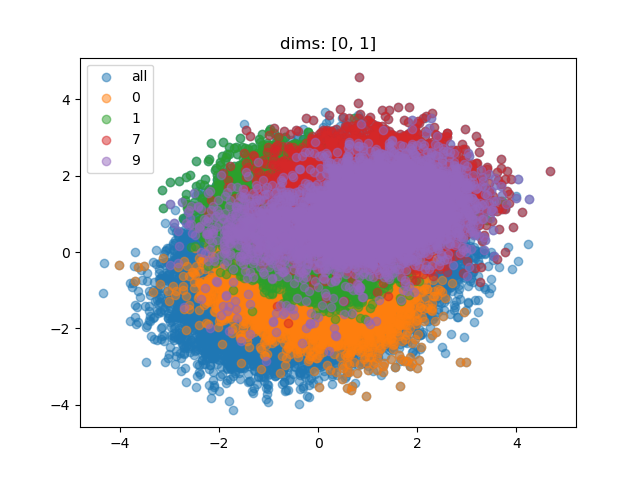

<IPython.core.display.Javascript object>


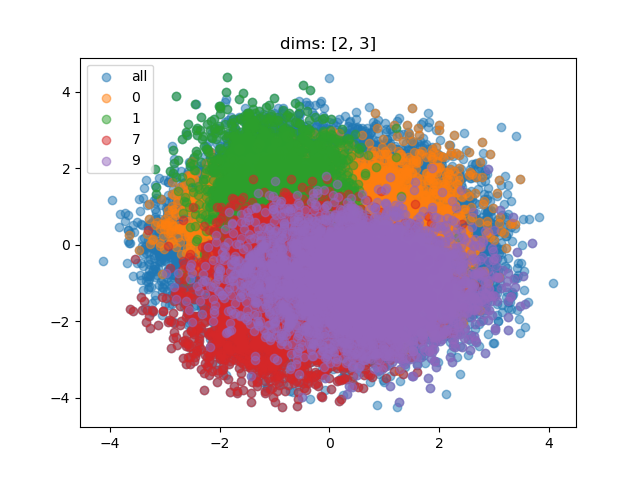

<IPython.core.display.Javascript object>


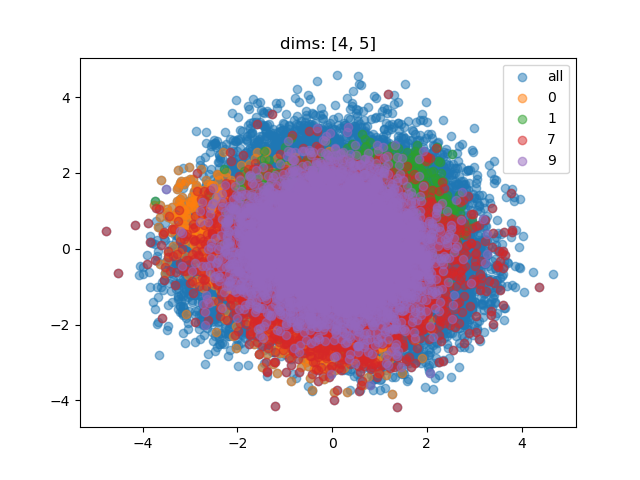

<IPython.core.display.Javascript object>


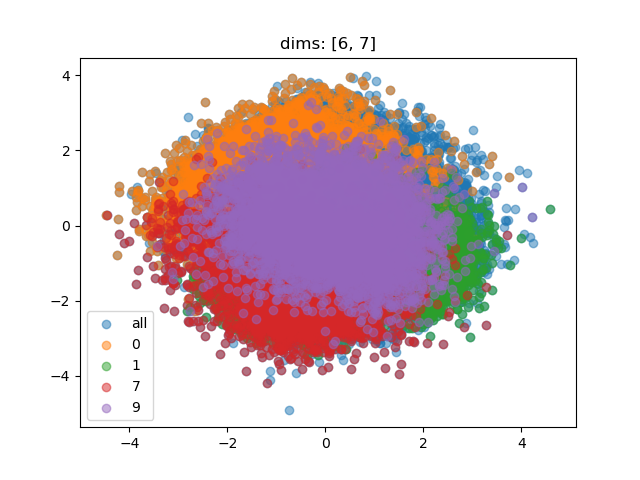

<IPython.core.display.Javascript object>


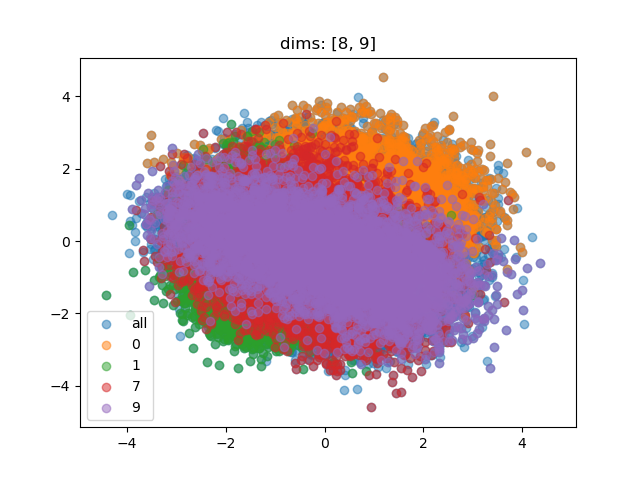

In [68]:
if figs is None:
    figs = range(len(proj_dims))
for fig_idx in figs:
    plt.figure(fig_idx)

In [70]:
figs = plot_projs(space, proj_dims, figs=figs, label='all', alpha=alpha)

In [71]:
x = 0
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [72]:
x = 1
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [49]:
x = 2
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [50]:
x = 3
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [51]:
x = 4
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [25]:
x = 5
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [26]:
x = 6
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [73]:
x = 7
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [28]:
x = 8
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)

In [74]:
x = 9
figs = plot_projs(space[labels==x,:], proj_dims, figs=figs, label=str(x), alpha=alpha)